In [1]:
# 匯入matplotlib.pyplot模組，用於繪圖
import matplotlib.pyplot as plt

# 匯入matplotlib.patches模組，用於繪製圖形元素
import matplotlib.patches as mpatches

# 匯入numpy套件，用於數值計算與陣列處理
import numpy as np

# 匯入OpenCV套件，用於影像處理
import cv2

# 匯入tempfile套件，用於建立臨時檔案
import tempfile

In [2]:
# 定義load_cascade_from_chinese_path函式，解決中文路徑讀取cascade XML檔案問題
def load_cascade_from_chinese_path(chinese_path: str):
    # 以二進位模式讀取cascade XML檔案內容，並用with語句確保檔案能被正確關閉
    with open(chinese_path, 'rb') as f:
        cascade_bytes = f.read()

    # 建立一個臨時檔案，路徑為純英文，避免中文路徑造成的讀取問題
    with tempfile.NamedTemporaryFile(delete = False, suffix=".xml") as tmpfile:
        # 將剛剛讀取的檔案內容寫入臨時檔案
        tmpfile.write(cascade_bytes)

        # 取得臨時檔案的路徑
        tmp_cascade_path = tmpfile.name

    # 使用臨時檔案路徑建立CascadeClassifier物件
    cascade = cv2.CascadeClassifier(tmp_cascade_path)

    # 傳回CascadeClassifier物件
    return cascade

In [3]:
# 定義cv_imread函式，用來讀取圖片檔案並傳回OpenCV格式的影像物件
def cv_imread(file_path):
    # 以二進位模式讀取圖片檔案內容，並用with語句確保檔案能被正確關閉
    with open(file_path, "rb") as f:
        stream = f.read()
    
    # 將二進位資料轉成numpy陣列，資料型態為uint8，方便後續影像解碼
    np_arr = np.frombuffer(stream, np.uint8)
    
    # 將numpy陣列解碼成OpenCV格式的彩色影像
    img = cv2.imdecode(np_arr, cv2.IMREAD_COLOR)
    
    # 傳回解碼後的影像物件
    return img

In [4]:
# 設定四個cascade XML檔案的完整路徑
face_cascade_path = r"E:\Colab第三階段202505\ch22_20250902\cascade_files\haarcascade_frontalface_default.xml"
eye_cascade_path = r"E:\Colab第三階段202505\ch22_20250902\cascade_files\haarcascade_eye.xml"
glasses_cascade_path = r"E:\Colab第三階段202505\ch22_20250902\cascade_files\haarcascade_eye_tree_eyeglasses.xml"
smile_cascade_path = r"E:\Colab第三階段202505\ch22_20250902\cascade_files\haarcascade_smile.xml"

# 設定兩張圖片檔的完整路徑，放入列表中
img_paths = [r"E:\Colab第三階段202505\ch22_20250902\Modi.jpg",
             r"E:\Colab第三階段202505\ch22_20250902\good.jpg"]

# 載入四個cascade檔案，利用臨時檔案避免中文路徑錯誤
face_cascade = load_cascade_from_chinese_path(face_cascade_path)
eye_cascade = load_cascade_from_chinese_path(eye_cascade_path)
glasses_cascade = load_cascade_from_chinese_path(glasses_cascade_path)
smile_cascade = load_cascade_from_chinese_path(smile_cascade_path)

# 檢查是否成功載入cascade檔案
if (face_cascade.empty() or eye_cascade.empty() or 
    glasses_cascade.empty() or smile_cascade.empty()):
    raise IOError("無法載入cascade檔案，請確認檔案路徑是否正確")

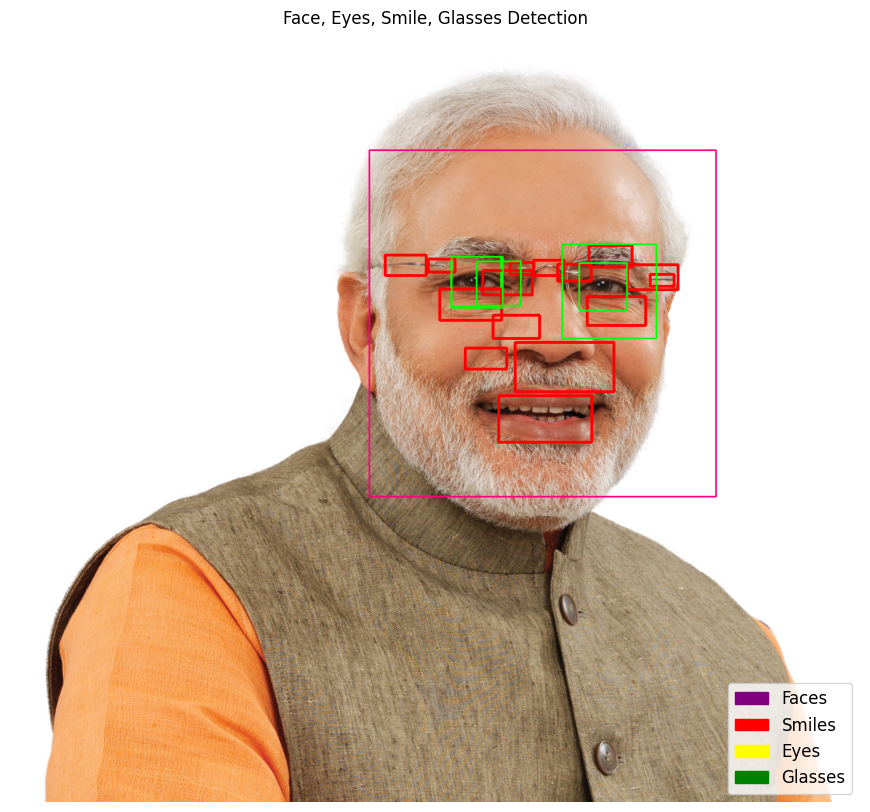

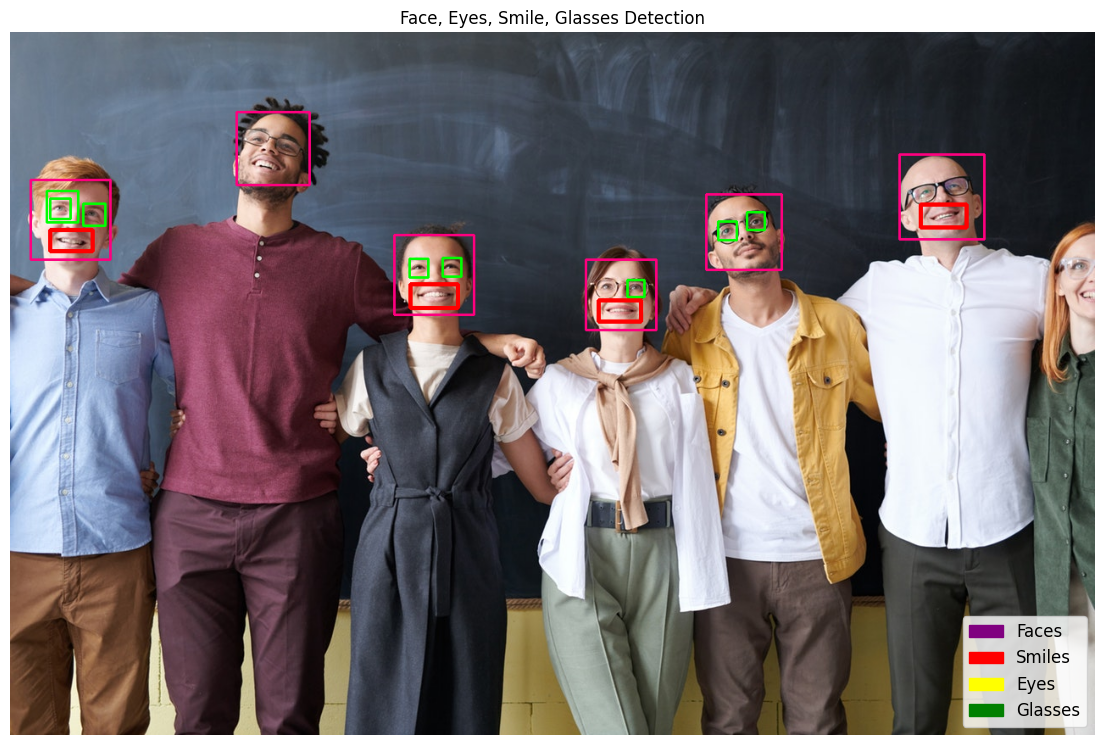

In [5]:
# 逐一讀取圖片清單中的每一張圖片進行處理
for img_path in img_paths:
    # 讀取圖片檔案(使用cv_imread解決中文路徑可能導致的讀取問題)
    image = cv_imread(img_path)

    # 檢查圖片是否成功讀取
    if image is None:
        raise IOError("無法讀取影像，請確認圖片路徑是否正確")
    
    # 將彩色圖片轉為灰階，Haar cascade偵測需灰階圖片
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 使用臉部分類器進行人臉偵測
    # gray：輸入的灰階影像，通常由彩色影像轉換而來，便於運算
    # scaleFactor：每次縮小影像尺寸的比例，用於建立影像金字塔(預設1.3)，表示每次縮小30%
    # minNeighbors：指定每個候選矩形需保留的鄰近矩形數量(預設5)，數值越大可減少誤偵測，但漏偵測風險會提高

    faces = face_cascade.detectMultiScale(gray, scaleFactor = 1.3, minNeighbors = 5)

    # 檢查是否成功擷取影像中的人臉
    if len(faces) == 0:
        print("未偵測到人臉，請確認影像內容是否正確")

    # 逐一畫出每個偵測到的人臉，並在圖片上畫偏紫紅色(BGR：127, 0, 255)框表示人臉
    for (x, y, w, h) in faces:
        cv2.rectangle(image, (x, y), (x + w, y + h), (127, 0, 255), 2)
    
        # 擷取人臉區域的灰階與彩色影像
        roi_gray = gray[y: y + h, x: x + w]
        roi_color = image[y: y + h, x: x + w]

        # 使用臉部分類器進行人臉偵測後，針對每張臉部區域進行眼睛偵測
        # roi_gray：臉部區域的灰階影像，用來限制偵測範圍，提高準確度
        # minSize = (30, 30)：眼睛大小的最小範圍，避免偵測到過小物件
        # maxSize = (130, 130)：眼睛大小的最大範圍，避免偵測到過大物件

        eyes = eye_cascade.detectMultiScale(roi_gray, minSize = (30, 30), maxSize = (130, 130))

        # 逐一畫出每個偵測到的眼睛，並在圖片上畫青色(BGR：255, 255, 0)框表示眼睛
        for (ex, ey, ew, eh) in eyes:
            cv2.rectangle(roi_color, (ex, ey), (ex + ew, ey + eh), (0, 255, 0), 2)

        # 使用臉部分類器進行人臉偵測後，針對每張臉部區域進行笑容偵測
        # roi_gray：臉部區域的灰階影像，限制偵測範圍
        # minNeighbors = 20：每個候選矩形需保留的鄰近矩形數量，數值越大可減少誤偵測，但可能導致漏偵測

        smiles = smile_cascade.detectMultiScale(roi_gray, minNeighbors = 20)

        # 逐一畫出每個偵測到的笑容，並在圖片上畫紅色(BGR：0, 0, 255)框表示笑容
        for (sx, sy, sw, sh) in smiles:
            cv2.rectangle(roi_color, (sx, sy), (sx + sw, sy + sh), (0, 0, 255), 3)

        # 使用臉部分類器進行人臉偵測後，針對每張臉部區域進行眼鏡偵測  
        # roi_gray：臉部區域的灰階影像，限制偵測範圍  
        # scaleFactor = 1.04：每次影像縮小的比例，值越小偵測越精細  
        # minNeighbors = 1：每個候選矩形需保留的鄰近矩形數量，數值越大可減少誤偵測，但可能導致漏偵測

        glasses = glasses_cascade.detectMultiScale(roi_gray, scaleFactor = 1.04, minNeighbors = 1)

        # 逐一畫出每個偵測到的眼鏡，並在圖片上畫綠色(BGR：0, 255, 0)框表示眼鏡
        for (gx, gy, gw, gh) in glasses:
            cv2.rectangle(roi_color, (gx, gy), (gx + gw, gy + gh), (0, 255, 0), 2)

    # 建立畫布，設定寬度為14吋、高度為10吋
    plt.figure(figsize = (14, 10))

    # 將OpenCV讀取的BGR影像轉換為RGB色彩空間並顯示圖片
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # 關閉座標軸顯示，讓圖片更乾淨
    plt.axis('off')

    # 建立圖例中代表人臉的顏色方塊，顏色為紫色，標籤為'Faces'
    face_patch = mpatches.Patch(color='purple', label='Faces')

    # 建立圖例中代表眼睛的顏色方塊，顏色為黃色，標籤為'Eyes'
    eye_patch = mpatches.Patch(color='yellow', label='Eyes')

    # 建立圖例中代表笑容的顏色方塊，顏色為紅色，標籤為'Smiles'
    smile_patch = mpatches.Patch(color='red', label='Smiles')

    # 建立圖例中代表眼鏡的顏色方塊，顏色為綠色，標籤為'Glasses'
    glass_patch = mpatches.Patch(color='green', label='Glasses')

    # 顯示圖例，並指定圖例位置在右下角，字體大小為12
    plt.legend(handles = [face_patch, smile_patch, eye_patch, glass_patch], loc='lower right', fontsize = 12)

    # 設定圖片標題，內容為「人臉、眼睛、笑容、眼鏡偵測」
    plt.title(f"Face, Eyes, Smile, Glasses Detection")

    # 顯示繪製完成的圖片視窗
    plt.show()

In [6]:
# 定義face_detector函式，用於即時攝影機影像中人臉及特徵(眼睛、笑容、眼鏡)偵測
def face_detector(img):
    # 將彩色圖片轉為灰階，Haar cascade偵測需灰階圖片
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 使用臉部分類器進行人臉偵測
    # gray：輸入的灰階影像，通常由彩色影像轉換而來，便於運算
    # scaleFactor：每次縮小影像尺寸的比例，用於建立影像金字塔(預設1.3)，表示每次縮小30%
    # minNeighbors：指定每個候選矩形需保留的鄰近矩形數量(預設5)，數值越大可減少誤偵測，但漏偵測風險會提高

    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    # 若未偵測到人臉，直接回傳原始影像
    if len(faces) == 0:
        return img

    # 逐一處理每個偵測到的人臉
    for (x, y, w, h) in faces:
        # 擴大人臉區域範圍(上下左右各擴張50像素)，避免裁切太緊
        x1 = max(0, x - 50)                 # 左邊界，往左擴張50像素，避免越界
        y1 = max(0, y - 50)                 # 上邊界，往上擴張50像素，避免越界
        x2 = min(img.shape[1], x + w + 50)  # 右邊界，往右擴張50像素，避免超出影像寬度
        y2 = min(img.shape[0], y + h + 50)  # 下邊界，往下擴張50像素，避免超出影像高度

        # 在圖片上畫藍色(BGR：255, 0, 0)框表示人臉擴大框，線寬為2
        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)

        # 擷取人臉擴大區域的灰階與彩色影像
        roi_gray = gray[y1:y2, x1:x2]
        roi_color = img[y1:y2, x1:x2]

        # 使用臉部分類器進行人臉偵測後，針對每張臉部區域進行眼睛偵測
        # roi_gray：臉部區域的灰階影像，用來限制偵測範圍，提高準確度

        eyes = eye_cascade.detectMultiScale(roi_gray)

        # 逐一畫出每個偵測到的眼睛，並在圖片上畫紅色(BGR：0, 0, 255)框表示眼睛，並設定線寬為2
        for (ex, ey, ew, eh) in eyes:
            cv2.rectangle(roi_color, (ex, ey), (ex + ew, ey + eh), (0, 0, 255), 2)
        
        # 使用臉部分類器進行人臉偵測後，針對每張臉部區域進行笑容偵測
        # roi_gray：臉部區域的灰階影像，限制偵測範圍
        # minNeighbors = 20：每個候選矩形需保留的鄰近矩形數量，數值越大可減少誤偵測，但可能導致漏偵測

        smiles = smile_cascade.detectMultiScale(roi_gray, minNeighbors = 20)

        # 逐一畫出每個偵測到的笑容，並在圖片上畫紅色(BGR：0, 0, 255)框表示笑容，線寬為3
        for (sx, sy, sw, sh) in smiles:
            cv2.rectangle(roi_color, (sx, sy), (sx + sw, sy + sh), (0, 0, 255), 3)


        # 使用臉部分類器進行人臉偵測後，針對每張臉部區域進行眼鏡偵測  
        # roi_gray：臉部區域的灰階影像，限制偵測範圍  
        # scaleFactor = 1.04：每次影像縮小的比例，值越小偵測越精細  
        # minNeighbors = 1：每個候選矩形需保留的鄰近矩形數量，數值越大可減少誤偵測，但可能導致漏偵測

        glasses = glasses_cascade.detectMultiScale(roi_gray, scaleFactor = 1.04, minNeighbors = 1)

        # 逐一畫出每個偵測到的眼鏡，並在圖片上畫綠色(BGR：0, 255, 0)框表示眼鏡，線寬為2       
        for (gx, gy, gw, gh) in glasses:
            cv2.rectangle(roi_color, (gx, gy), (gx + gw, gy + gh), (0, 255, 0), 2)

    # 傳回已繪製標記的影像
    return img

In [7]:
# 開啟預設攝影機(編號0表示第一個攝影機裝置)
cap = cv2.VideoCapture(0)

# 檢查攝影機是否成功開啟，若無法開啟則顯示錯誤訊息並結束程式
if not cap.isOpened():
    print("無法開啟攝影機")
    exit()

# 使用while迴圈持續讀取攝影機影像
while True:
    # 從攝影機讀取一幀影像，ret表示讀取成功與否，frame為影像陣列
    ret, frame = cap.read()
    
    # 檢查是否成功擷取影像
    if not ret:
        print("無法讀取影像，請確認路徑是否正確")
        break

    # 顯示視窗名稱為'Face Detector'的影像視窗，內容為標記出人臉的影像
    cv2.imshow('Face Detector', frame)

    # 等待鍵盤輸入，1毫秒刷新一次畫面，並與0xFF做AND運算確保相容性
    key = cv2.waitKey(1) & 0xFF

    # 如果使用者有按下任何鍵(非255)，就跳出迴圈
    if key != 255:
        break

# 釋放攝影機資源並關閉所有OpenCV視窗
cap.release()
cv2.destroyAllWindows()